### Imports

In [1]:
import boto3
import dask
import dilib
import os
import pathlib
import pytz
from collections import defaultdict
from datetime import datetime, timedelta
from typing import Any

import pandas as pd
import numpy as np
import rich

from epoch_data import athena
from epoch_data import calendarlib
from epoch_data import hdstorelib
from epoch_infra import commonlib
from epoch_infra import clusterlib
from epoch_infra import joblib
from epoch_markets import symlib
from epoch_markets.mdcatalog.options import data_config, instr_helper, job, job_config
from epoch_markets.symlib import options

from octopus import refdata_options
from octopus import datelib
from octopus import archives

In [2]:
from __future__ import annotations

### Helpers - General

In [3]:
def get_secmaster(path_prefix: str="/fsxcache/output") -> symlib.SecMaster:
    data_client = hdstorelib.MainDataClient(
        protocol="file",
        host=None,
        name_resolver=None,
        network_latency=None,
        path_prefix=path_prefix
    )

    fronts_factory = symlib.FrontsFactory(
        data_client=data_client,
        base_path="secdef",
        front_scheme="mft_rel",
        ignore_missing_products=True,
    )

    secmaster = symlib.SecMaster(
        data_client=data_client,
        base_path="secdef",
        fronts_factory=fronts_factory,        
    )

    return secmaster

secmaster = get_secmaster()


def get_mapping_from_gsym(gsym: str) -> symlib.InstrumentMapping:
    return symlib.InstrumentKey.get_instrument_mapping(gsym)


def get_futures(
    gsym: str,
    trade_date: datetime.date,
) -> list[symlib.Instrument]:
    res = set()
    for offset in range(1, 3):
        key = symlib.InstrumentKey(gsym, trade_date, offset)
        res.add(secmaster.get_instrument(key))
    return list(res)


def get_options(
    gsym: str,
    start_date: datetime.date,
    end_date: datetime.date,
    is_complex: bool,
) -> list[symlib.Instrument]:
    res = []
    for trade_date in calendar.get_date_range(
        start_date, end_date, isoweekdays={1, 2, 3, 4, 5}
    ):
        res.extend(instr_helper.get_options(gsym, trade_date, trade_date, 0, is_complex=is_complex, secmaster=secmaster))
    return list(set(res))


def get_exchange_symbols(
    gsym: str,
    trade_date: datetime.date,
    is_complex: bool,
) -> list[str]:
    ids = instr_helper.get_exchange_symbols_and_sec_ids(trade_date, trade_date, calendar, gsym, is_complex=is_complex, secmaster=secmaster)
    return [i.exchange_symbol for i in ids]


# read a book parquet file for some symbol
# e.g. data = client.gather(client.compute(dask.delayed(get_book_data)("03Tzyk", calendar.get_date(20230921, forward=True), version)))
def get_book_data(exchange: str, gsym: str, symbol: str, trade_date: calendarlib.TradeDate, version: str):
    # /{fsx_location}/books/cboe/2023/01/03/v5/{symbol}/book.parquet
    args = dict(exchange=exchange, year=trade_date.year, month=trade_date.month_padded, 
                day=trade_date.day_padded, version=version, symbol=symbol, gsym=gsym)
    if exchange == "cme":
        book_location = "/fsxcache/output/books/{exchange}/{gsym}/{year}/{month}/{day}/{version}/{symbol}"
    elif exchange == "cboe":
        book_location = "/fsxcache/output/books/{exchange}/{year}/{month}/{day}/{version}/{symbol}"
    elif exchange == "nymx":
        book_location = "/fsxcache/output/books/{exchange}/{year}/{month}/{day}/{version}/{symbol}"
    path = book_location.format(**args)
    print (path)
    files = ["book", "trades"]
    ret = {}
    for f in files:
        ret[f] = pd.read_parquet(f"{path}/{f}.parquet")
    return ret

def get_outright_1m_price_data_cache_hashes(trade_date: calendarlib.TradeDate, keys: list[symlib.OptionSpecificInstrumentKey]):
    data_context = athena.DataContext(read_namespaces=["prod"], write_namespace="prod")
    container = data_config.get_options_container(data_context=data_context)
    core_market_dataset = container.config.core_market_dataset
    res = {}
    for key in keys:
        if exchange == "cme":
            res[key.exchange_security_id] = core_market_dataset.get_outright_1m_price_data(key, version).cache_protocol.data_hash
        else:
            res[key.exchange_symbol] = core_market_dataset.get_outright_1m_price_data(key, version).cache_protocol.data_hash
        return res

def validate_cached_downsampled_files(gsym: str, trade_date: calendarlib.TradeDate, keys: list[symlib.OptionSpecificInstrumentKey]):
    res_list = []
    cache_hashes = get_outright_1m_price_data_cache_hashes(trade_date, keys)
    for exchange_symbol, cache_hash in cache_hashes.items():
        path = f"/fsxcache/output/prod/derived/options_core_market/v1/outright_1m_price_data/v0/{cache_hash}/{exchange_symbol}/{trade_date}.pickle"
        res = dict(symbol=exchange_symbol, date=trade_date, file_location=path)
        res[f"ds_file_exists"] = os.path.exists(path)
        res_list.append(res)
    return res_list

In [4]:
"""
Relatively standalone arb-checking tools for Zeno.

See the "Arb-Uniform" LP in Joel's Zeno notes for an explanation:
    http://mftshare/joel.gibson/notes_html/Zeno/Arbitrage%20in%20OSPXW%20and%20OESW.html
Although what is done here is slightly different in the treatment of the wings.
"""

from __future__ import annotations

import numpy as np
import scipy.optimize


def create_gross_payoff(strike: np.ndarray, pc_flag: np.ndarray):
    """
    Create a gross payoff matrix of shape (S, A), where S is the number of distrinct strikes in the
    problem, and gross_payoff[i, j] is the payoff of contract j at the ith strike.

    Input are two vectors of the same length A:
    - strike[i] is the strike price of the ith contract.
    - pc_flag[i] is 'C' for calls and 'P' for puts.
    """
    A = len(strike)
    assert strike.shape == pc_flag.shape == (A,)

    # The elbows are the sample points in price space.
    elbow = np.unique(strike)
    E = len(elbow)

    # Convert the put-call flag into +1 for calls, and -1 for puts.
    pc_sign = np.where(pc_flag == 'C', 1.0, -1.0)

    # The payoff matrix has shape (E, 2A), a horizontally-stacked matrix of [buy, sell].
    # The entry [e, a] is the payoff for buying the ath contract, if the underlying finishes at e.
    # The entry [e, A + a] is the payoff for selling.
    # Add a dummy column at the end for t.
    payoff = np.zeros((E, A), dtype=float)
    for i in range(A):
        payoff[:, i] = np.maximum(pc_sign[i] * (elbow - strike[i]), 0.0)

    return payoff


def arb_uniform(
    gross_payoff: np.ndarray,  # (S, A)
    pc_flag: np.ndarray,  # (A)
    bid: np.ndarray,  # (A)
    ask: np.ndarray,  # (A)
) -> tuple[float, np.ndarray, np.ndarray]:  # (1, (A), (A))
    """
    Check a collection of option prices (of length A) for arbitrage, at a single point in time.

    Inputs:
    - gross_payoff: Shape (S, A) representing payoffs at strikes.
    - pc_flag: Shape (A), either 'C' for call or 'P' for put.
    - bid, ask: Shape (A), bid and ask prices, or NaN if the price does not exist.

    Returns a pair (payoff, buy_weight, sell_weight) of the maximum uniform payoff (a scalar)
    achievable, and two shape (A) vectors of weights to use to buy/sell to achieve this payoff.
    If the payoff scalar is positive, there is an arbitrage.

    Usually one would expect there to be no cancellation in buy_weight - sell_weight, i.e. if we
    are buying something we don't sell it, and vice-versa. However, since we are forcing the buy
    and sell weights to collectively add to 1, sometimes we are forced to both buy and sell the same
    contract (especially in a dataset of only one contract)!.
    """
    S, A = gross_payoff.shape
    assert pc_flag.shape == bid.shape == ask.shape == (A,)
    assert np.all((pc_flag == 'C') | (pc_flag == 'P'))

    # Our linear program is the following:
    # Maximise min_payoff = [0 | 0 | 1] ⋅ [buy | sell | min_payoff]
    #   Over (2A + 1) variables:
    #                buy ≥ 0, of length A,
    #               sell ≥ 0, of length A,
    #         min_payoff ∈ ℝ, scalar
    #   With the constraints:
    #     L1 (S)  [ gross_payoff - 1 @ askᵀ | 1 @ bidᵀ - gross_payoff | -1 ] @ [buy | sell | t] ≥ 0
    #     L2 (1)  [ call_indicator          | - call_indicator        |  0 ] @ [buy | sell | t] ≥ 0
    #     L3 (1)  [ put_indicator           | - put_indicator         |  0 ] @ [buy | sell | t] ≥ 0
    #     E4 (1)  [ 1 1 1 1 1 1 1 1 1 1 1 1 | 1 1 1 1 1 1 1 1 1 1 1 1 |  0 ] @ [buy | sell | t] = 1
    #
    # Constraint L1 is saying that net_payoff(buy, sell) evaluated at the strike k is ≥ t, for all
    # strikes k. Since the objective is to maximise t, this means at any optimal solution t will be
    # the minimum net payoff at any strike. Constraint L2 says that the gradient of the payoff curve
    # after the largest strike is zero or positive (this gradient is the net weight of calls).
    # Similarly, constraint L3 says that the gradient on the left of the smallest strike is
    # negative, i.e. increases to the left. Finally, constraint E4 forces the weights to sum to 1.
    #
    # There are other details:
    # 1. scipy.optimise.linprog wants to accept a constraint like L @ x ≤ b rather than L @ x ≥ b.
    #    So we end up negating our L matrix.
    # 2. scipy.optimise.linprog wants to minimise instead of maximise. So we negate our objective
    #    vector, and negate the final value of the program as well.
    # 2. Buy variables (and corresponding constraint columns) where the ask are NaN are removed
    #    entirely from the problem, and similarly for missing bid prices.
    #
    # Since buy, sell ≥ 0 and constraint E4, the buy and sell variables are bounded. Hence t is also
    # bounded provided there is at least one nonzero column in L1. If all bids and asks are NaN,
    # then t will be unbounded. So we should early return from this case. Any buy and sell in bounds
    # can be extended to a feasible point by taking t low enough, so the LP is always feasible.

    # Mask of variables: only present buys, present sells, and always t.
    mask = np.concatenate([~np.isnan(ask), ~np.isnan(bid), [True]])
    if mask[:2*A].sum() == 0:
        return 0.0, np.zeros(A, dtype=float), np.zeros(A, dtype=float)

    # Objective function
    obj = np.zeros(2 * A + 1, dtype=float)
    obj[-1] = 1

    # We could construct this a bit at a time or as a block matrix and both ways are gross...
    L = np.zeros((S + 2, 2 * A + 1), dtype=float)

    # L1
    L[0:S, 0:A] += gross_payoff
    L[0:S, 0:A] -= ask
    L[0:S, A:2*A] -= gross_payoff
    L[0:S, A:2*A] += bid
    L[0:S, -1] = -1.0

    # L2
    L[S, 0:A] = np.where(pc_flag == 'C', 1.0, 0.0)
    L[S, A:2*A] = np.where(pc_flag == 'C', -1.0, 0.0)

    # L3
    L[S+1, 0:A] = np.where(pc_flag == 'P', 1.0, 0.0)
    L[S+1, A:2*A] = np.where(pc_flag == 'P', -1.0, 0.0)

    # E4
    E = np.zeros((1, 2 * A + 1))
    E[:, 0:2*A] = 1

    # Run the solver. We disable the presolve since our constraint matrix is small and interesting
    # enough that it can never reduce the problem anyway. (I think the rows are positively indep
    # and so there is no reduction to be done). Unfortunately Scipy will convert this to a sparse
    # matrix and then give it to HiGHS even though it's dense...
    result = scipy.optimize.linprog(
        c=-obj[mask],
        A_ub=-L[:, mask],
        b_ub=np.zeros(S + 2, dtype=float),
        A_eq=E[:, mask],
        b_eq=np.array([1.0]),
        bounds=[(0, None)] * mask[:2*A].sum() + [(None, None)],
        options=dict(presolve=False),
        method='highs-ds',
    )

    # Since the problem is bounded and feasible, this should always succeed.
    assert result.success

    # Unpack the weights from the mask.
    weight = np.zeros(2*A, dtype=float)
    weight[mask[:-1]] = result.x[:-1]

    return -result.fun, weight[:A], weight[A:]

In [5]:
from __future__ import annotations

import pytest
import dataclasses

import numpy as np
import numpy.testing

@dataclasses.dataclass
class OptData:
    pc: str
    strike: float
    bid: float
    ask: float


@pytest.mark.parametrize('insts, expected_payoff', [
    # A one-sided call: the only possible move is to buy it.
    ([OptData('C', 1000.0, np.nan, 3.0)], -3.0),

    # A two-sided call: the best move is to buy half and sell half.
    # (Can't sell more than we buy, else the payoff curve becomes negative somewhere).
    ([OptData('C', 1000.0, 1.0, 3.0)], -1.0),

    # A call and a put at the same strike. These should be independent, so same result as before.
    ([OptData('C', 1000.0, 1.0, 3.0), OptData('P', 1000.0, 1.0, 3.0)], -1.0),

    # Two calls with a short call spread giving an arb. The best choice is to sell the first and
    # buy the second, for a uniform payoff of
    #   Bid(1000) - Ask(1000) - (1020 - 1000) = (23 - 2) - 20 = 1.0
    # Since weights sum to 1, this will be a payoff of 0.5 here.
    ([OptData('C', 1000.0, 23.0, 24.0), OptData('C', 1020.0, 1.0, 2.0)], 0.5),

    # If the first call is worth a little less, the short call spread is not an arb.
    ([OptData('C', 1000.0, 21.0, 24.0), OptData('C', 1020.0, 1.0, 2.0)], -0.5),
])
def test_arb_uniform_option(insts: list[OptData], expected_payoff: float):
    strike = np.array([inst.strike for inst in insts], dtype='float')
    pc_flag = np.array([inst.pc for inst in insts])
    bid = np.array([inst.bid for inst in insts], dtype='float')
    ask = np.array([inst.ask for inst in insts], dtype='float')

    gross_payoff = zeno.arb.create_gross_payoff(strike, pc_flag)
    payoff, buy, sell = zeno.arb.arb_uniform(gross_payoff, pc_flag, bid, ask)

    numpy.testing.assert_allclose(payoff, expected_payoff)
    assert np.all(buy >= 0)
    assert np.all(sell >= 0)
    numpy.testing.assert_allclose(buy.sum() + sell.sum(), 1.0)


### Helpers - Specific

In [6]:
def get_ch_refdata():
    with refdata_options.get_opt_refdata_dao(refdata_options.OptRefdataDao.TABLE_NAME_V2) as dao:
        return dao.get_all_refdata()

In [7]:
def get_market_data(trade_date, ch_refdata, base_asset, pcap_ch_table):
    print (f'Getting market data for {trade_date}')
    
    expiry_date = np.datetime64(trade_date)
    refdata_options = ch_refdata[(ch_refdata.base_asset == base_asset) & (ch_refdata.expiry_date == expiry_date)]
    times_begin = refdata_options.expiry_timestamp[0].replace(hour=0, minute=0, second=0).tz_localize('UTC')
    times_end = refdata_options.expiry_timestamp[0].tz_localize('UTC')
    db_archives = archives.ClickArchive(pcap_ch_table)
    pcap_df = (
            db_archives.load_symbols_between_times(
            symbols=refdata_options.symbol.unique(),
            begin=times_begin,
            end=times_end,
            columns=['ask', 'bid', 'mid', 'ask_size', 'bid_size'],
            )
        )
    db_archives = archives.ClickArchive('historical.trthopt_1min_v7')
    trth_df = (
            db_archives.load_symbols_between_times(
            symbols=refdata_options.symbol.unique(),
            begin=times_begin,
            end=times_end,
            columns=['ask', 'bid', 'mid', 'ask_size', 'bid_size'],
            )
        )
    pcap_df.set_index(['timestamp'], drop=False, inplace=True)
    pcap_df.sort_index(inplace=True)
    trth_df.set_index(['timestamp'], drop=False, inplace=True)
    trth_df.sort_index(inplace=True)
    
    return trth_df, pcap_df

In [8]:
def check_options_count(d: datetime.date, base_asset:str, option_chain: list[symlib.Instrument], ch_refdata: pd.DataFrame, checks):
    expiry_date = np.datetime64(d)
    oesw_refdata_options = ch_refdata[(ch_refdata.base_asset == base_asset) & (ch_refdata.expiry_date == expiry_date)]
    if len(oesw_refdata_options.index) == len(option_chain):
        print (f'CHECK - Options Count - SUCCESS ({len(option_chain)})')
        checks['options_count'] = True
    else:
        print ('CHECK - Options Count - ERROR')
        checks['options_count'] = False
        print(f'Refinitiv: {len(oesw_refdata_options.index)} - PCAP: {len(option_chain)}')

In [9]:
def check_boundaries(trth_df, pcap_df, checks):
    trth_min_timestamp = trth_df.timestamp.min()
    trth_max_timestamp = trth_df.timestamp.max()
    pcap_min_timestamp = pcap_df.timestamp.min()
    pcap_max_timestamp = pcap_df.timestamp.max()
    if trth_min_timestamp == pcap_min_timestamp and trth_max_timestamp == pcap_max_timestamp:
        print (f'CHECK - Timestamp boundaries - SUCCESS {trth_min_timestamp} -> {trth_max_timestamp}')
        checks['timestamp_boundaries'] = True
    else:
        print ('CHECK - Timestamp boundaries - ERROR')
        print (f'Min Timestamp: trth:{trth_min_timestamp} pcap:{pcap_min_timestamp} equal:{trth_min_timestamp == pcap_min_timestamp}')
        print (f'Max Timestamp: trth:{trth_max_timestamp} pcap:{pcap_max_timestamp} equal:{trth_max_timestamp == pcap_max_timestamp}')
        checks['timestamp_boundaries'] = False

In [10]:
def remove_missing_timestamps(sym_trth, sym_pcap):
    # Remove missing timestamps when refinitiv does not have them
    # This happens when the prices is the same between minutes
    # I am unsure if it is Refinitiv and Post Processing in MFT
    trth_index_missings = sym_pcap.index.difference(sym_trth.index)
    return sym_pcap.drop(trth_index_missings)

def remove_timestamps_with_nans(sym_trth, sym_pcap):
    nan_index = sym_pcap[(sym_pcap.bid.isna()) | (sym_pcap.ask.isna())].index
    sym_trth_temp = sym_trth.drop(nan_index)
    sym_pcap_temp = sym_pcap.drop(nan_index)
    nan_index = sym_trth_temp[(sym_trth_temp.bid.isna()) | (sym_trth_temp.ask.isna())].index
    sym_trth_final = sym_trth_temp.drop(nan_index)
    sym_pcap_final = sym_pcap_temp.drop(nan_index)
    return sym_trth_final, sym_pcap_final

def check_incorrect_data(trth_df, pcap_df, checks):
    trth_neg      = trth_df[(trth_df.bid < 0) | (trth_df.ask < 0)]
    trth_no_nan   = trth_df.dropna()
    trth_in_cross = trth_no_nan[trth_no_nan.bid >= trth_no_nan.ask]
    checks['incorrect_data_trth'] = len(trth_neg.index) + len(trth_in_cross.index)

    pcap_neg      = pcap_df[(pcap_df.bid < 0) | (pcap_df.ask < 0)]
    pcap_no_nan   = pcap_df.dropna()
    pcap_in_cross = pcap_no_nan[pcap_no_nan.bid >= pcap_no_nan.ask]
    checks['incorrect_data_pcap'] = len(pcap_neg.index) + len(pcap_in_cross.index)

    if len(trth_in_cross.index) > 0:
        checks['options_to_remove'].extend(trth_in_cross.symbol.unique())
    if len(pcap_in_cross.index) > 0:
        checks['options_to_remove'].extend(pcap_in_cross.symbol.unique())


def check_option(trade_date, symbol: str, trth_df, pcap_df, checks):
    sym_trth = trth_df[(trth_df.symbol == symbol)]
    sym_pcap = pcap_df[(pcap_df.symbol == symbol)]


    # We know that we could have missing timestamps in both sides and we just want to check the
    # ones in common
    sym_pcap_filtered = remove_missing_timestamps(sym_trth, sym_pcap)
    sym_trth_filtered = remove_missing_timestamps(sym_pcap_filtered, sym_trth)

    # We remove the nans as the logic in Refinitiv is dodgy
    sym_trth_filtered, sym_pcap_filtered = remove_timestamps_with_nans(sym_trth_filtered, sym_pcap_filtered)

    # Log how many timestamps we have a difference
    results = pd.DataFrame()
    results['bid'] = sym_trth_filtered.bid.ge(sym_pcap_filtered.bid) | np.isclose(sym_trth_filtered.bid, sym_pcap_filtered.bid)
    results['ask'] = sym_trth_filtered.bid.ge(sym_pcap_filtered.ask) | np.isclose(sym_trth_filtered.ask, sym_pcap_filtered.ask)
    issues = results[~results.bid| ~results.ask] 
    checks['options'][symbol] = (len(issues.index), issues)
    if len(issues.index) > 15:
        checks['options_not_similar_15'] += 1
        print(f'Please check - differences for {symbol} = {len(issues.index)} on day {trade_date}')
    if len(issues.index) > 30:
        checks['options_not_similar_30'] += 1
        print(f'REALLY Please check - differences for {symbol} = {len(issues.index)} on day {trade_date}')

In [11]:
def get_payoffs(data, opt_symbols, times, pcf, gross_payoff):
    mkt_data = {
        col: numpy.array(
            [
                *[
                    data[opt][col].to_numpy()
                    if opt in data
                    else numpy.full(len(times), numpy.nan)
                    for opt in opt_symbols
                ]
            ]
        ).T
        for col in ['ask', 'mid', 'bid', 'ask_size', 'bid_size']
    }
    results = []
    for idx in range(0, len(times)):
        payoff, buy, sell = arb_uniform(gross_payoff, pcf, mkt_data['bid'][idx], mkt_data['ask'][idx])
        results.append(payoff)
    return results

In [12]:
def arb_check(refdata_options, trth_df, pcap_df, checks, normal_hours_start_local, normal_hours_end_local):
    
    times_begin = refdata_options.expiry_timestamp[0].replace(hour=0, minute=0, second=0).tz_localize('UTC')
    times_end = refdata_options.expiry_timestamp[0].tz_localize('UTC')      
    opt_symbols = refdata_options.symbol.unique()

    for opt in checks['options_to_remove']:
        opt_symbols = np.delete(opt_symbols, np.where(opt_symbols == opt))
    
    point_values = np.array([*list(refdata_options.loc[opt_symbols, 'point_value'])])
    pcf = np.array([*list(refdata_options.loc[opt_symbols, 'pc'])])
    strikes = np.array([*list(refdata_options.loc[opt_symbols, 'strike_price'])])
    gross_payoff = create_gross_payoff(strikes, pcf)
    times = pd.date_range(times_begin, times_end, inclusive='left', freq='1T', name='datetime')
    trth_data = {
        symbol: frame.drop('symbol', axis='columns').set_index('timestamp').reindex(times)
        for symbol, frame in trth_df.groupby('symbol', sort=False)
    }
    pcap_data = {
        symbol: frame.drop('symbol', axis='columns').set_index('timestamp').reindex(times)
        for symbol, frame in pcap_df.groupby('symbol', sort=False)
    }
    trth_results = get_payoffs(trth_data, opt_symbols, times, pcf, gross_payoff)
    pcap_results = get_payoffs(pcap_data, opt_symbols, times, pcf, gross_payoff)
    results = pd.DataFrame(
        {'TRTH': trth_results,
         'PCAP': pcap_results
        }, index=times)
    ax = results.plot()
    ax.axhline(0, ls='--', color='black', alpha=0.5)

    checks['trth_arbs_over_0'] = len(results[results.TRTH > 0].TRTH)
    checks['trth_arbs_very_over_0'] = len(results[results.TRTH > 1.e-6].TRTH)
    checks['pcap_arbs_over_0'] = len(results[results.PCAP > 0].PCAP)
    checks['pcap_arbs_very_over_0'] = len(results[results.PCAP > 1.e-6].PCAP)
    
    results_normal_hours = results[(results.index >= normal_hours_start_local) & (results.index <=  normal_hours_end_local)]
    checks['trth_arbs_over_0_normal_hours'] = len(results_normal_hours[results_normal_hours.TRTH > 0].TRTH)
    checks['trth_arbs_very_over_0_normal_hours'] = len(results_normal_hours[results_normal_hours.TRTH > 1.e-6].TRTH)
    checks['pcap_arbs_over_0_normal_hours'] = len(results_normal_hours[results_normal_hours.PCAP > 0].PCAP)
    checks['pcap_arbs_very_over_0_normal_hours'] = len(results_normal_hours[results_normal_hours.PCAP > 1.e-6].PCAP)

### Program

In [13]:
ch_refdata = get_ch_refdata()

2024-02-28 01:25:18,473 420932 INFO using /Shared/andre.ribes/SourceProjects/opt_data/mft-config/clickhouse-map.yaml
2024-02-28 01:25:18,477 420932 INFO clickhouse map (historical.opt_refdata_v2, read, sy5) -> prod-chous01 historical.opt_refdata_v2
2024-02-28 01:25:18,730 420932 INFO using /Shared/andre.ribes/SourceProjects/opt_data/mft-dist/etc/meta.yaml


In [14]:
data_context = athena.DataContext(read_namespaces=["test", "prod"], write_namespace="test")
container = data_config.get_options_container(data_context=data_context)
core_market_dataset = container.config.core_market_dataset
source_market_dataset = container.config.source_market_dataset

In [15]:
test = "OESW"
#dates_to_check = ["20230818"]
#dates_to_check = ["20230801", "20230802", "20230803", "20230804", "20230807", "20230808", "20230809", "20230810", "20230811", "20230814", "20230815", "20230816", "20230817", "20230818", "20230821", "20230822", "20230823", "20230824", "20230828", "20230829"]
dates_to_check = ["20230706", "20230707", "20230711", "20230712", "20230721", "20230725", "20230726", "20230727", "20230728"]

### OESW parameters

In [16]:
if test == "OESW":
    gsym = "OES"
    base_asset = "OESW"
    version = "v2.2"
    is_complex = False
    pcap_ch_table = 'historical.oes_1min_pcap_v1'
    exchange = symlib.Exchanges.CME.name.lower()
    calendar = container.config.ref_data_config.cme_calendar
    normal_hours_start_local = pd.Timestamp('20000101 08:30:00').tz_localize(tz='America/Chicago')
    normal_hours_end_local = pd.Timestamp('20000101 15:00:00').tz_localize(tz='America/Chicago')

### OSPXW parameters

In [17]:
if test == "OSPXW":
    gsym = "OSPXW"
    base_asset = "OSPXW"
    version = "v5"
    is_complex = False
    pcap_ch_table = 'historical.spxw_1min_v1'
    exchange = symlib.Exchanges.CBOE.name.lower()
    calendar = container.config.ref_data_config.cboe_calendar
    normal_hours_start_local = pd.Timestamp('20000101 08:30:00').tz_localize(tz='America/Chicago')
    normal_hours_end_local = pd.Timestamp('20000101 15:00:00').tz_localize(tz='America/Chicago')

In [18]:
trade_dates = [calendar.get_date(i, forward=True) for i in dates_to_check]

In [19]:
def check_one_day(trade_date, gsym, base_asset, ch_refdata, pcap_ch_table, normal_hours_start_local, normal_hours_end_local):

    print (f'Checking date {trade_date}')
    
    normal_hours_start_local = normal_hours_start_local.replace(year=trade_date.year, month=trade_date.month, day=trade_date.day)
    normal_hours_end_local = normal_hours_end_local.replace(year=trade_date.year, month=trade_date.month, day=trade_date.day)

    checks = {
        'options_count': False,
        'timestamp_boundaries': False,
        'options_not_similar_15': 0,
        'options_not_similar_30': 0,
        'incorrect_data_trth': 0,
        'incorrect_data_pcap': 0,
        'trth_arbs_over_0': 0,
        'trth_arbs_very_over_0': 0,
        'pcap_arbs_over_0': 0,
        'pcap_arbs_very_over_0': 0,
        'trth_arbs_over_0_normal_hours': 0,
        'trth_arbs_very_over_0_normal_hours': 0,
        'pcap_arbs_over_0_normal_hours': 0,
        'pcap_arbs_very_over_0_normal_hours': 0,
        'options_to_remove': [],
        'options': {}
    }
    option_chain = get_options(gsym, trade_date, trade_date, False)
    check_options_count(trade_date, base_asset, option_chain, ch_refdata, checks)
    expiry_date = np.datetime64(trade_date)
    refdata_options = ch_refdata[(ch_refdata.base_asset == base_asset) & (ch_refdata.expiry_date == expiry_date)]

    trth_df, pcap_df = get_market_data(trade_date, ch_refdata, base_asset, pcap_ch_table)
    check_boundaries(trth_df, pcap_df, checks)
    check_incorrect_data(trth_df, pcap_df, checks)

    for symbol in refdata_options.symbol:
        check_option(trade_date, symbol, trth_df, pcap_df, checks)

    print ("Starting arb check")
    arb_check(refdata_options, trth_df, pcap_df, checks, normal_hours_start_local, normal_hours_end_local)
    return checks

2024-02-28 01:25:46,193 420932 ERROR security group info not found for file:///fsxcache/output/secdef/2023/07/EW.20230706.secdef.json.gz


Checking date 20230706
CHECK - Options Count - ERROR
Refinitiv: 544 - PCAP: 0


2024-02-28 01:25:46,504 420932 INFO using /Shared/andre.ribes/SourceProjects/opt_data/mft-config/clickhouse-map.yaml
2024-02-28 01:25:46,508 420932 INFO clickhouse map (historical.oes_1min_pcap_v1, read, sy5) -> prod-chous01 historical.oes_1min_pcap_v1


Getting market data for 20230706


2024-02-28 01:25:46,787 420932 INFO using /Shared/andre.ribes/SourceProjects/opt_data/mft-config/clickhouse-map.yaml
2024-02-28 01:25:46,790 420932 INFO clickhouse map (historical.trthopt_1min_v7, read, sy5) -> prod-chous01 historical.trthopt_1min_v7


CHECK - Timestamp boundaries - SUCCESS 2023-07-06 00:00:00+00:00 -> 2023-07-06 19:59:00+00:00
Please check - differences for E1D1W4375G23 = 16 on day 20230706
Starting arb check


2024-02-28 01:27:55,615 420932 ERROR security group info not found for file:///fsxcache/output/secdef/2023/07/EW.20230707.secdef.json.gz


Checking date 20230707
CHECK - Options Count - ERROR
Refinitiv: 606 - PCAP: 0
Getting market data for 20230707
CHECK - Timestamp boundaries - SUCCESS 2023-07-07 00:00:00+00:00 -> 2023-07-07 19:59:00+00:00
Please check - differences for ES1W4330G23 = 17 on day 20230707
Please check - differences for ES1W4365G23 = 17 on day 20230707
Please check - differences for ES1W4395G23 = 18 on day 20230707
Please check - differences for ES1W4400G23 = 19 on day 20230707
Please check - differences for ES1W4410G23 = 18 on day 20230707
Please check - differences for ES1W4475S23 = 17 on day 20230707
Please check - differences for ES1W4490S23 = 16 on day 20230707
Starting arb check


2024-02-28 01:30:21,720 420932 ERROR security group info not found for file:///fsxcache/output/secdef/2023/07/EW.20230711.secdef.json.gz


Checking date 20230711
CHECK - Options Count - ERROR
Refinitiv: 540 - PCAP: 0
Getting market data for 20230711
CHECK - Timestamp boundaries - SUCCESS 2023-07-11 00:00:00+00:00 -> 2023-07-11 19:59:00+00:00
Please check - differences for E1B2W4440G23 = 16 on day 20230711
Starting arb check


2024-02-28 01:32:17,475 420932 ERROR security group info not found for file:///fsxcache/output/secdef/2023/07/EW.20230712.secdef.json.gz


Checking date 20230712
CHECK - Options Count - ERROR
Refinitiv: 520 - PCAP: 0
Getting market data for 20230712
CHECK - Timestamp boundaries - SUCCESS 2023-07-12 00:00:00+00:00 -> 2023-07-12 19:59:00+00:00
Please check - differences for EC2W1800G23 = 16 on day 20230712
Please check - differences for EC2W2000G23 = 16 on day 20230712
Please check - differences for EC2W2300G23 = 16 on day 20230712
Please check - differences for EC2W3000G23 = 16 on day 20230712
Please check - differences for EC2W3925G23 = 16 on day 20230712
Please check - differences for EC2W4000G23 = 16 on day 20230712
Please check - differences for EC2W4450G23 = 16 on day 20230712
Please check - differences for EC2W4455G23 = 16 on day 20230712
Please check - differences for EC2W4465G23 = 20 on day 20230712
Please check - differences for EC2W4485G23 = 18 on day 20230712
Please check - differences for EC2W4550S23 = 17 on day 20230712
Starting arb check


2024-02-28 01:34:16,371 420932 ERROR security group info not found for file:///fsxcache/output/secdef/2023/07/EW.20230721.secdef.json.gz


Checking date 20230721
CHECK - Options Count - ERROR
Refinitiv: 662 - PCAP: 0
Getting market data for 20230721
CHECK - Timestamp boundaries - SUCCESS 2023-07-21 00:00:00+00:00 -> 2023-07-21 19:59:00+00:00
Please check - differences for ES3W4560S23 = 16 on day 20230721
Starting arb check


2024-02-28 01:37:23,959 420932 ERROR security group info not found for file:///fsxcache/output/secdef/2023/07/EW.20230725.secdef.json.gz


Checking date 20230725
CHECK - Options Count - ERROR
Refinitiv: 542 - PCAP: 0
Getting market data for 20230725
CHECK - Timestamp boundaries - SUCCESS 2023-07-25 00:00:00+00:00 -> 2023-07-25 19:59:00+00:00
Starting arb check


2024-02-28 01:39:35,720 420932 ERROR security group info not found for file:///fsxcache/output/secdef/2023/07/EW.20230726.secdef.json.gz


Checking date 20230726
CHECK - Options Count - ERROR
Refinitiv: 541 - PCAP: 0
Getting market data for 20230726
CHECK - Timestamp boundaries - SUCCESS 2023-07-26 00:00:00+00:00 -> 2023-07-26 19:59:00+00:00
Starting arb check


2024-02-28 01:42:22,020 420932 ERROR security group info not found for file:///fsxcache/output/secdef/2023/07/EW.20230727.secdef.json.gz


Checking date 20230727
CHECK - Options Count - ERROR
Refinitiv: 538 - PCAP: 0
Getting market data for 20230727
CHECK - Timestamp boundaries - SUCCESS 2023-07-27 00:00:00+00:00 -> 2023-07-27 19:59:00+00:00
Starting arb check


2024-02-28 01:45:00,999 420932 ERROR security group info not found for file:///fsxcache/output/secdef/2023/07/EW.20230728.secdef.json.gz


Checking date 20230728
CHECK - Options Count - ERROR
Refinitiv: 598 - PCAP: 0
Getting market data for 20230728
CHECK - Timestamp boundaries - SUCCESS 2023-07-28 00:00:00+00:00 -> 2023-07-28 19:59:00+00:00
Please check - differences for ES4W1100G23 = 16 on day 20230728
Please check - differences for ES4W1300G23 = 16 on day 20230728
Please check - differences for ES4W1400G23 = 16 on day 20230728
Please check - differences for ES4W1700G23 = 17 on day 20230728
Please check - differences for ES4W1900G23 = 16 on day 20230728
Please check - differences for ES4W2100G23 = 16 on day 20230728
Please check - differences for ES4W2200G23 = 16 on day 20230728
Please check - differences for ES4W2300G23 = 16 on day 20230728
Please check - differences for ES4W2400G23 = 18 on day 20230728
Please check - differences for ES4W2550G23 = 17 on day 20230728
Please check - differences for ES4W2650G23 = 16 on day 20230728
Please check - differences for ES4W2850G23 = 19 on day 20230728
Please check - differences 

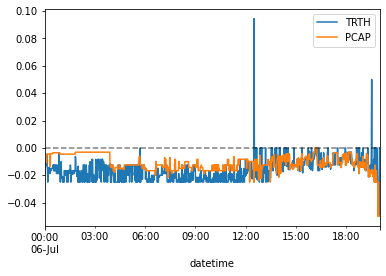

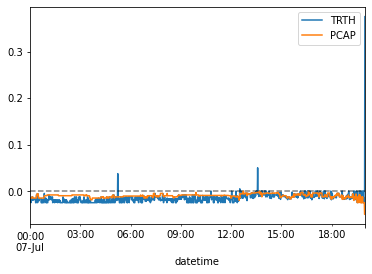

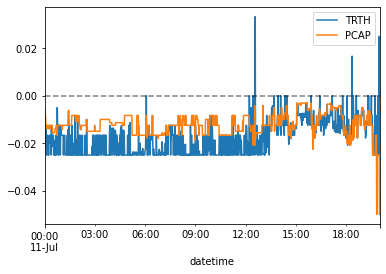

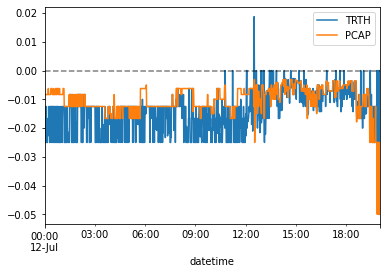

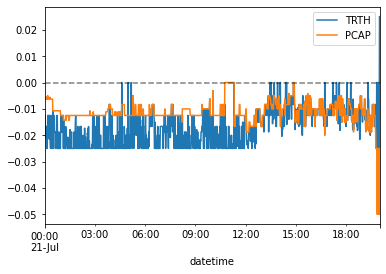

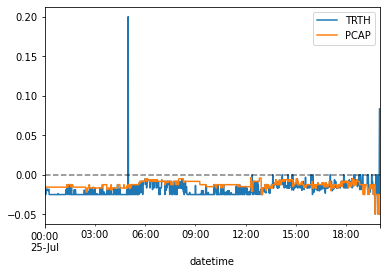

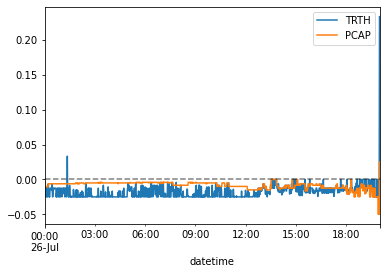

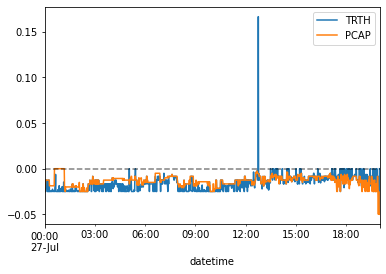

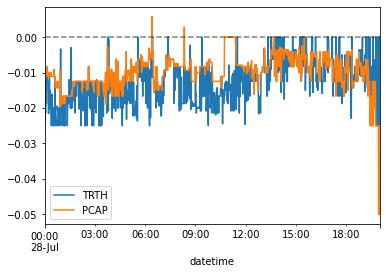

In [20]:
results = {}
for trade_date in trade_dates:
    results[trade_date] = check_one_day(trade_date, gsym, base_asset, ch_refdata, pcap_ch_table, normal_hours_start_local, normal_hours_end_local)

In [21]:
r = pd.DataFrame.from_dict(results, orient='index', columns=['options_count', 'timestamp_boundaries', 'options_not_similar_15', 'options_not_similar_30', 'incorrect_data_trth', 'incorrect_data_pcap', 'trth_arbs_over_0', 'trth_arbs_very_over_0', 'pcap_arbs_over_0', 'pcap_arbs_very_over_0', 'trth_arbs_over_0_normal_hours', 'trth_arbs_very_over_0_normal_hours', 'pcap_arbs_over_0_normal_hours', 'pcap_arbs_very_over_0_normal_hours'])
r.T

20230706 20230707 20230711 20230712  \
options_count                         False    False    False    False   
timestamp_boundaries                   True     True     True     True   
options_not_similar_15                    1        7        1       11   
options_not_similar_30                    0        0        0        0   
incorrect_data_trth                       0        0        0        0   
incorrect_data_pcap                       0        0        0        0   
trth_arbs_over_0                          4        9        7        4   
trth_arbs_very_over_0                     2        4        3        1   
pcap_arbs_over_0                          1        0        0        0   
pcap_arbs_very_over_0                     0        0        0        0   
trth_arbs_over_0_normal_hours             3        6        6        1   
trth_arbs_very_over_0_normal_hours        1        2        2        0   
pcap_arbs_over_0_normal_hours             1        0        0        0   
pcap_arbs_very_over_0_normal_hours        0        0        0        0   

                                   20230721 20230725 20230726 20230727  \
options_count                         False    False    False    False   
timestamp_boundaries                   True     True     True     True   
options_not_similar_15                    1        0        0        0   
options_not_similar_30                    0        0        0        0   
incorrect_data_trth                       0        0        0        0   
incorrect_data_pcap                       0        0        0        0   
trth_arbs_over_0                          4        6       10       10   
trth_arbs_very_over_0                     1        2        2        1   
pcap_arbs_over_0                          7        0        5        6   
pcap_arbs_very_over_0                     0        0        1        0   
trth_arbs_over_0_normal_hours             2        5        9        8   
trth_arbs_very_over_0_normal_hours        1        1        1        0   
pcap_arbs_over_0_normal_hours             0        0        5        0   
pcap_arbs_very_over_0_normal_hours        0        0        1        0   

                                   20230728  
options_count                         False  
timestamp_boundaries                   True  
options_not_similar_15                  170  
options_not_similar_30                    0  
incorrect_data_trth                       0  
incorrect_data_pcap                       0  
trth_arbs_over_0                          9  
trth_arbs_very_over_0                     1  
pcap_arbs_over_0                          6  
pcap_arbs_very_over_0                     2  
trth_arbs_over_0_normal_hours             5  
trth_arbs_very_over_0_normal_hours        0  
pcap_arbs_over_0_normal_hours             0  
pcap_arbs_very_over_0_normal_hours        0